In [1650]:
# Hyperparameters
POPULATION_SIZE = 10
MAXIMUM_WEIGHT = 529    #529
NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP = 3
ITERATIONS = 20
EACH_TYPE_ONE_ELEMENT = 0

### GA的順序
evalutation $\rightarrow$ selection $\rightarrow$ crossover $\rightarrow$ mutation
### 要注意的地方
1. 除了 Equipment, 每種 Type 只能選一個 Item.
2. Maximum weight 529 units. (後暫時更改為450)
3. At least one knife, one pistol and one equipment in inventory bag.
4. 指定GA內部operators - 使用 roulette-wheel selection, uniform crossover (p=0.1), multi bit flip
5.

* 下列組合 - extra credits (依 主武器、副武器、小刀 及 裝備 排序）
    * (Leone YG1265, Desert Eagle, - , shield) S.P. +25
    * (Krieg 500, Desert Eagle, - , shield) S.P. +25
    * All three equipments packed (Gas Mask + NV Goggle + Shield) S.P. +70

#### Data Processing

In [1651]:
#### read csv files as dataframe
import pandas as pd
import numpy as np

List_of_Gear = pd.read_csv('List_of_gear.csv')
List_of_Gear

,Item,Type,Weight,Survival_Points
0,Shadow_Daggers,Knife,3.3,7
1,Huntsman_Knife,Knife,3.4,8
2,Gut_Knife,Knife,6.0,13
3,228_Compact_Handgun,Pistols,26.1,29
4,Night_Hawk,Pistols,37.6,48
5,Desert_Eagle_Magnum,Pistols,62.5,99
6,Ingram_MAC-10_SMG,Primary,100.2,177
7,Leone_YG1265_Auto_Shotgun,Primary,141.1,213
8,M4A1_Carbine,Primary,119.2,202
9,AK-47_Rifle,Primary,122.4,210


In [1652]:
df = List_of_Gear.iloc[:,0]
print(df)

0                Shadow_Daggers
1                Huntsman_Knife
2                     Gut_Knife
3           228_Compact_Handgun
4                    Night_Hawk
5           Desert_Eagle_Magnum
6             Ingram_MAC-10_SMG
7     Leone_YG1265_Auto_Shotgun
8                  M4A1_Carbine
9                   AK-47_Rifle
10      Krieg_550_Sniper_Rifles
11             M249_Machine_Gun
12                     Gas_Mask
13          Night-Vision_Goggle
14              Tactical_Shield
Name: Item, dtype: object


#### Pre-work for later data processing

In [1653]:
## Create an Item - Weight mapping
Weight_Map = List_of_Gear.iloc[:,2].to_numpy()
#print(Weight_Map)
## Create an Item - Survival_Points mapping
Survival_Points_Map = List_of_Gear.iloc[:,3].to_numpy()
#print(Survival_Points_Map)

#### Some Methods

In [1654]:
import numpy as np

def Check_Overweight(Given_Array):
    Weight = Weight_Mapping(Given_Array)
    if Weight <= MAXIMUM_WEIGHT:
        return 0
    else:
        #print(f'Over Weight!, weight={Weight}')
        return 1

def Survival_Points_Mapping(Given_Array):
    Sum_of_Survival_Points = 0
    for i in range(len(Given_Array)):
        if Given_Array[i] == 1:
            Sum_of_Survival_Points += Survival_Points_Map[i]
    # Extra Points
        ## YG1265 or Krieg 500 + Desert Eagle + tactical shield, survival points +25
    if(((Given_Array[7]==1)|(Given_Array[10]==1))&(Given_Array[5]==Given_Array[14]==1)):
        Sum_of_Survival_Points += 25
        ## shadow dagger + desert eagle, survival points +5
    elif(Given_Array[0]==Given_Array[5]==1):
        Sum_of_Survival_Points += 5
        ## 228 Compact + AK-47 or M4A1, survival points +15
    elif(((Given_Array[8]==1)|(Given_Array[9]==1))&(Given_Array[4]==1)):
        Sum_of_Survival_Points += 15
        ## Carry all three equipments, survial points +70
    elif(Given_Array[12]==Given_Array[13]==Given_Array[14]==1):
        Sum_of_Survival_Points += 70
    else:
        pass
    return Sum_of_Survival_Points

def Weight_Mapping(Given_Array):
    Sum_of_weight = 0
    for i in range(len(Given_Array)):
        if Given_Array[i] == 1:
            Sum_of_weight += Weight_Map[i]
    return Sum_of_weight

def Randomly_Select_A_Row_from_Matrix(Given_Matrix):
    number_of_rows = Given_Matrix.shape[0]
    random_indicies = np.random.choice(number_of_rows, size=1, replace=False)
    Selected_Row = Given_Matrix[random_indicies, :]
    Selected_Row = np.squeeze(Selected_Row)
    return Selected_Row

def Generate_Single_Creature(Each_Type_One_Element):

    if(Each_Type_One_Element==1):
    # Except equipments, we can only choose one item in each type.
    # I will set the initial choice of each items by utilizing np.eye matrix,\
    # \then randomly select a row in order to represent the collection of items chosen.
        Knife = np.eye(3, dtype=int); Pistols = np.eye(3, dtype=int); Primary = np.eye(6, dtype=int);
        Selected_Knife = Randomly_Select_A_Row_from_Matrix(Knife)
        Selected_Pistols = Randomly_Select_A_Row_from_Matrix(Pistols)
        Selected_Primary = Randomly_Select_A_Row_from_Matrix(Primary)
        Equipments = np.random.randint(2, size=3, dtype=int)
        Items_in_Bag = np.concatenate((Selected_Knife, Selected_Pistols, Selected_Primary, Equipments))
    else:
        Items_in_Bag = np.random.randint(2, size=15)

    if Check_Overweight(Items_in_Bag)==0:
        return Items_in_Bag
    else:
        return Generate_Single_Creature(Each_Type_One_Element)   #Recursive Call till no overweight

def Generate_Population(Each_Type_One_Element):
    Population = []
    for i  in range(POPULATION_SIZE):
        Single_Creature = Generate_Single_Creature(Each_Type_One_Element)
        #Single_Creature = np.array(Single_Creature)
        Population.append(Single_Creature)
    #print(f'Population successfully created.')
    #print(f'Population shape:{np.array(Population).shape}')
    return Population

def Roulete_Wheel_Selection(Given_Matrix):

    A = []
    max = -np.inf
    for i in range(len(Population)):
        survial_point = Survival_Points_Mapping(Population[i])
        A.append(survial_point)
        if survial_point > max:
            max = survial_point
    #print(f'A:{A}')
    #print(f'max:{max}')

    sum = 0
    for j in range(len(Population)):
        #sum = sum + np.max([1,max-A[j]])
        sum += A[j]
        A[j] = sum
    #print(A)

    Matepool = []
    for k in range(int(len(Population)/2)):
        a = np.random.randint(sum)
        #print(f'a:{a}')
        i=0
        while(a>A[i]):
            i += 1
        Matepool.append(Population[i])
    #print(f'Matepool:\n{Matepool}')
    #print(f'shape of Matepool: {np.array(Matepool).shape}')

    return Matepool


def Uniform_Crossover(Given_Matrix):
    Test_Matrix = Given_Matrix
    for i in range(int(len(Test_Matrix)/2)):

        for j in range(int(len(Test_Matrix[i]))):
            a = np.random.uniform(0,1,1)
            if a >= 0.5:
                # SWAP the elements among two weapons lists.
                Test_Matrix[2*i][j], Test_Matrix[2*i+1][j] = Test_Matrix[2*i+1][j], Test_Matrix[2*i][j]

    number_of_weapon_lists_overweight = 0

    # Check any of the weapon lists are overweight
    for i in range(int(len(Test_Matrix))):
        number_of_weapon_lists_overweight += Check_Overweight(Test_Matrix[i])

    if number_of_weapon_lists_overweight == 0:
        return Test_Matrix
    else:
        return Uniform_Crossover(Given_Matrix)
        #If there is an weapon lists exceed pack weight constraint, \
        # \then we'll do the Uniform_Crossover step again.

def Multi_Bit_Flip_Mutation(Given_Matrix, Number_of_Pairs_of_Multi_Bit_Flip):
    Test_Matrix = Given_Matrix
    # I double the population size in the step to make the amount of creatures fixed in each generations.
    Test_Matrix = np.concatenate((Test_Matrix, Test_Matrix))
    for i in range(int(len(Test_Matrix)/2)):
        for j in range(Number_of_Pairs_of_Multi_Bit_Flip):
            interchange_location = np.random.randint(int(len(Test_Matrix[i])),size=2)
            Test_Matrix[i][interchange_location[0]], Test_Matrix[i][interchange_location[1]] =\
            Test_Matrix[i][interchange_location[1]], Test_Matrix[i][interchange_location[0]]

    number_of_weapon_lists_overweight = 0

    # Check any of the weapon lists are overweight
    for i in range(int(len(Test_Matrix))):
        number_of_weapon_lists_overweight += Check_Overweight(Test_Matrix[i])

    if number_of_weapon_lists_overweight == 0:
        return Test_Matrix
    else:
        return Multi_Bit_Flip_Mutation(Given_Matrix, NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP)
        #If there is an weapon lists exceed pack weight constraint, \
        # \then we'll do the "Multi_Bit_Flip_Mutation" step again.

def Get_the_Best_Combination(Given_Matrix):
    max = -np.inf
    for i in range(len(Given_Matrix)):
        if Survival_Points_Mapping(Given_Matrix[i]) > max:
            max = Survival_Points_Mapping(Given_Matrix[i])
            best_combination = Given_Matrix[i]
    print(f'   The best combination in the current generation is: {best_combination}'
          f'\n    with maximum survival points: {max}'
          f', and total weight: {Weight_Mapping(best_combination):.1f}')
    return max, best_combination
    #return 0

#### Let's Start

In [1655]:
best_offspring_in_each_generation = []
max_SP_over_all_generation = -np.inf
Population = Generate_Population(Each_Type_One_Element=EACH_TYPE_ONE_ELEMENT)

for iters in range(ITERATIONS):
    print(f'\n===== Generation: {iters+1} =====')
    Selected_Creatures = Roulete_Wheel_Selection(Population)
    Syngamy = Uniform_Crossover(Selected_Creatures)
    Next_Generation = Multi_Bit_Flip_Mutation(Syngamy, NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP)
    Population = Next_Generation
    max_SP_of_current_generation, best_combination_of_current_generation = Get_the_Best_Combination(Next_Generation)

    if (max_SP_of_current_generation > max_SP_over_all_generation):
        best_combination_over_all_generation = best_combination_of_current_generation
        max_SP_over_all_generation = max_SP_of_current_generation

    print(f'   The best combination over all generation is: {best_combination_over_all_generation}'
          f'\n    with correspond items: ', end=" ")

    for i in range(len(best_combination_over_all_generation)):
        if best_combination_over_all_generation[i] == 1:
            print(f'{df[i]} +', end=" ")
    print(f'\n    and maximum survival points: {max_SP_over_all_generation}'
            f', total weight: {Weight_Mapping(best_combination_over_all_generation):.1f}')
    best_offspring_in_each_generation.append(max_SP_over_all_generation)


===== Generation: 1 =====
   The best combination in the current generation is: [0 0 1 0 1 1 1 0 1 1 0 0 1 1 0]
    with maximum survival points: 785, and total weight: 504.2
   The best combination over all generation is: [0 0 1 0 1 1 1 0 1 1 0 0 1 1 0]
    with correspond items:  Gut_Knife + Night_Hawk + Desert_Eagle_Magnum + Ingram_MAC-10_SMG + M4A1_Carbine + AK-47_Rifle + Gas_Mask + Night-Vision_Goggle + 
    and maximum survival points: 785, total weight: 504.2

===== Generation: 2 =====
   The best combination in the current generation is: [1 1 0 1 0 1 1 1 0 1 0 0 0 0 1]
    with maximum survival points: 783, and total weight: 501.5
   The best combination over all generation is: [0 0 1 0 1 1 1 0 1 1 0 0 1 1 0]
    with correspond items:  Gut_Knife + Night_Hawk + Desert_Eagle_Magnum + Ingram_MAC-10_SMG + M4A1_Carbine + AK-47_Rifle + Gas_Mask + Night-Vision_Goggle + 
    and maximum survival points: 785, total weight: 504.2

===== Generation: 3 =====
   The best combination in th

#### Plot the result of GA

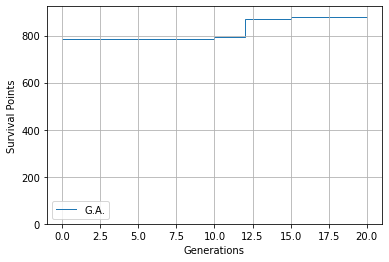

In [1656]:
import matplotlib.pyplot as plt
plt.stairs(best_offspring_in_each_generation, label='G.A.', baseline=None)

plt.xlabel('Generations')
plt.ylabel('Survival Points')

plt.grid()

plt.legend(loc=0)

plt.show()


#### Test

In [1657]:
A = np.zeros(3)
print(A)

A = np.concatenate((A,A))
print(A)

[0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
